In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

In [177]:
#
# Set various fundamental parameters
#
# Minimum change in ADC value before recomputing illumination target
#
D_DELTA = 0.01
#
# Lowest and highest possible ADC values, these values to be
# determined by observation. The input is clamped within this
# range to protect later computations.
#
ADC_LEVELS = 4096
ADC_MIN = 250
ADC_MAX = ADC_LEVELS - 250
ADC_RANGE = ADC_MAX - ADC_MIN
#
# Number of increments when a new target is set
#
INCREMENTS = 20


class DimmerLamp:
    def __init__(self, pin):
        self.pin = pin
        self.adc = ADC(pin)
        self.current = self.increment = self.target = self.ticks_left = 0
        
    @property
    def demand(self):
        "Return current normalised demand value."
        adc_val = 3280   # Read ADC value
        if adc_val < ADC_MIN:
            adc_val = ADC_MIN
        if adc_val > ADC_MAX:
            adc_val = ADC_MAX
        return (adc_val - ADC_MIN) / ADC_RANGE
    
    def tick(self):
        """
        Sample ADC input to set new target if necessary,
        then increment current value towards target.
        """
        if abs(self.target - self.demand) > D_DELTA:
            self.target = self.demand
            self.increment = (self.target - self.current) / INCREMENTS
            self.ticks_left = INCREMENTS
        if self.ticks_left:
            self.ticks_left -= 1
            self.current += self.increment
        return self.current*64, int((self.current*64)**2)


In [178]:
dl = DimmerLamp(2)

In [179]:
ticks = [dl.tick() for i in range(30)]
linear_out = [t[0] for t in ticks]
control_out = [t[1] for t in ticks]

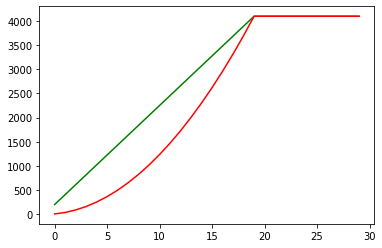

In [180]:
plt.plot(range(30), [t*64 for t in linear_out], color='green')
plt.plot(range(30), control_out, color='red')

The following refactoring tries to improve readability by using
more self-explanatory names. It also moves the computation of
anything but the ADC reading values in the range $[0, 4095]$
outside the `user_setting` property definition.

This allows us to more easily mock the actual method with a test method that
allows us to see how the lamp will react to posited user operations.

In [313]:
#
# Set various fundamental parameters
#
# Minimum change in ADC value before recomputing illumination target
#
D_DELTA = 0.01
#
# Lowest and highest possible ADC values, these values to be
# determined by observation. The input is clamped within this
# range to protect later computations.
#
ADC_LEVELS = 4096
ADC_MIN = 250
ADC_MAX = ADC_LEVELS - 250
ADC_RANGE = ADC_MAX - ADC_MIN
#
# Total time in mS to respond to a new target level.
# This is a premature optimisation, since there is as
# yet no evidence that a constant response time is
# desirable.
#
RESPONSE_TIME = 2000
#
# Tick period in mS
#
TICK_PERIOD = 50
#
# Number of increments when a new target is set
#
INCREMENTS = 25


class DimmerLamp:
    def __init__(self, pin):
        self.pin = pin
        self.current_level = 0
        self.level_delta = 0
        self.target_level = 0
        self.ticks_left = 0

    @property
    def user_setting(self):
        "Return current normalised demand value from user."
        adc_val = 4095   # Read ADC value
        if adc_val < ADC_MIN:
            adc_val = ADC_MIN
        if adc_val > ADC_MAX:
            adc_val = ADC_MAX
        return (adc_val - ADC_MIN) / ADC_RANGE

    def tick(self):
        """
        Sample ADC input to set new target if necessary,
        then increment current value towards target.
        """
        setting = self.user_setting
        if abs(self.target_level - setting) > D_DELTA:
            self.target_level = setting
            self.level_delta = (self.target_level - self.current_level) / INCREMENTS
            self.ticks_left = INCREMENTS
        if self.ticks_left:
            self.ticks_left -= 1
            self.current_level += self.level_delta
        return self.current_level


This little bit of code lets us generate samples from the potentiometer.
It's in a raw cell so the notebook doesn't try to execute it.

In [319]:
dl = DimmerLamp("Mock for testing")

# periods = ((35, 4095), (35, 2047), (15,0), (22, 255), (22, 3071), (25, 4095), (50, 0))
# # Emulate rotation of the dial and idle to allow completion
# periods += tuple((50, x) for x in range(0, 4095, 256)) +((50, 4095), )
# setting_values = [x for (n, x) in periods for _ in range(n)]
setting_values = [207, 208, 208, 208, 208, 208, 209, 208, 208, 208, 209, 206, 212, 224, 339, 421, 537, 2085,
                  3116, 3374, 3510, 3504, 3504, 3505, 3504, 3504, 4095, 4095, 4094, 4095, 4095, 4094, 4095,
                  4093, 4089, 4095, 4093, 4095, 3959, 3799, 3617, 3458, 3270, 3074, 2880, 2652, 2410, 2096,
                  1767, 1372, 905, 465, 5, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 0, 4, 4, 4, 6, 3, 642, 1711, 1585,
                  416, 285, 1646, 2174, 754, 679, 2118, 2743, 2674, 1805, 592, 135, 616, 2067, 2907, 2697,
                  1509, 1137, 2745, 2218, 1594, 3135, 3833, 4095, 4095, 4095, 4095, 4094, 4094, 4094, 4079,
                  4094, 4093, 3326, 2591, 1860, 1717, 1713, 1718, 1749, 1078, 500, 2, 3, 4, 3, 2, 4, 4, 114,
                  575, 1080, 1611, 2216, 2782, 3163, 3458, 3685, 3795, 3797, 3800, 3796, 3796, 3717, 3565,
                  3337, 2972, 2451, 1879, 1423, 941, 749, 734, 641, 705, 1081, 1496, 1839, 2208, 2477, 2717,
                  3083, 3419, 3684, 3858, 3972, 4042, 4094, 4095, 4046, 3939, 3834, 3742, 3647, 3567, 3497,
                  3433, 3364, 3255, 3140, 3039, 2947, 2856, 2738, 2608, 2518, 2411, 2232, 2067, 1935, 1811,
                  1694, 1557, 1451, 1350, 1254, 1157, 1139, 1197, 1304, 1379, 1468, 1556, 1630, 1694, 1738,
                  1798, 1874]

[
    2966, 2966, 2965, 2966, 2967, 2966, 2967, 2967, 2967, 2967, 2967, 2967, 2967, 2967, 2966, 2966, 2966, 2966,
    2966, 2966, 2966, 2965, 2967, 2965, 2966, 2966, 2966, 2964, 2966, 2965, 2992, 2971, 3137, 3679, 4094, 4093,
    4095, 4095, 4095, 4093, 4095, 4029, 3282, 2668, 1985, 1373, 1012, 805, 785, 788, 735, 433, 4, 8, 3, 2, 4,
    3, 4, 4, 92, 485, 865, 1432, 2048, 2666, 3156, 3589, 3859, 4094, 4094, 4095, 4095, 4095, 4095, 4095, 4095,
    4095, 4031, 3709, 3358, 2935, 2489, 1962, 1582, 1119, 711, 433, 190, 2, 2, 4, 4, 4, 4, 3, 4, 3, 4, 2, 3,
    4, 4, 4, 0, 3, 3, 0, 3, 4, 3, 4, 4, 4, 4, 55, 114, 165, 217, 273, 304, 350, 398, 430, 456, 507, 533, 556,
    598, 627, 665, 818, 1751, 2972, 3204, 2955, 1670, 512, 504, 2146, 3234, 3612, 2859, 1243, 286, 3, 4, 4,
    4, 2, 3, 4, 4, 4, 5, 3, 4, 76, 291, 421, 520, 664, 807, 947, 1054, 1149, 1245, 1354, 1458, 1584, 1753, 1930,
    2058, 2212, 2361, 2456, 2517, 2586, 2677, 2775, 2893, 2972, 3025, 3034, 2989, 2868, 2751, 2636, 2490, 2335,
    2189, 2040, 1940, 1846, 1729, 1641, 1560, 1486, 1410, 1323
]
setting_value = iter(setting_values)

@property
def mock_setting(s):
    return next(setting_value)

DimmerLamp.user_setting = mock_setting

In [320]:
print(f"Tick count: {len(setting_values)}")
light_settings = [dl.tick() for _ in setting_values]

Tick count: 200


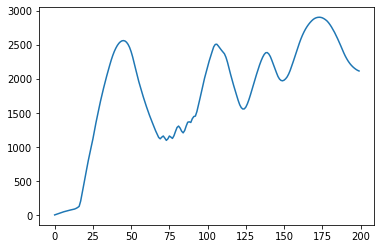

In [321]:
plt.plot(light_settings)

In [322]:
for t in enumerate(tick_value):
    print(t)

This refactoring gets stored to a file that can be transferred to a PyBoard using only filestore!
Finally we can get to testing the real device.

In [308]:
import pyb
#
# Set various fundamental parameters
#
# Minimum change in ADC value before recomputing illumination target
#
D_DELTA = 0.01
#
# Lowest and highest possible ADC values, these values to be
# determined by observation. The input is clamped within this
# range to protect later computations.
#
ADC_LEVELS = 4096
ADC_MIN = 250
ADC_MAX = ADC_LEVELS - 250
ADC_RANGE = ADC_MAX - ADC_MIN
#
# Total time in mS to respond to a new target level.
# This is a premature optimisation, since there is as
# yet no evidence that a constant response time is
# desirable.
#
RESPONSE_TIME = 2000
#
# Tick period in mS
#
TICK_PERIOD = 50
#
# Number of increments when a new target is set
#
INCREMENTS = 25

#
# Set up hardware
#
adc = pyb.ADC(pyb.Pin.board.Y11)  # Establish ADC connection

class DimmerLamp:
    def __init__(self, pin):
        self.pin = pin
        self.current_level = 0
        self.level_delta = 0
        self.target_level = 0
        self.ticks_left = 0

    @property
    def user_setting(self):
        "Return current normalised demand value from user."
        adc_val = adc.read()   # Read ADC value
        if adc_val < ADC_MIN:
            adc_val = ADC_MIN
        if adc_val > ADC_MAX:
            adc_val = ADC_MAX
        return (adc_val - ADC_MIN) / ADC_RANGE

    def tick(self):
        """
        Sample ADC input to set new target if necessary,
        then increment current value towards target.
        """
        setting = self.user_setting
        if abs(self.target_level - setting) > D_DELTA:
            self.target_level = setting
            self.level_delta = (self.target_level - self.current_level) / INCREMENTS
            self.ticks_left = INCREMENTS
        if self.ticks_left:
            self.ticks_left -= 1
            self.current_level += self.level_delta
        return self.current_level


ModuleNotFoundError: No module named 'pyb'